In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
# from opendp.smartnoise.synthesizers.mwem import MWEMSynthesizer
from snsynth import MWEMSynthesizer
from snsynth import QUAILSynthesizer
from snsynth.pytorch import PytorchDPSynthesizer
from snsynth.pytorch.nn import DPCTGAN

from diffprivlib.models import LogisticRegression as DPLR

# from opendp.smartnoise.synthesizers.quail import QUAILSynthesizer

# from opendp.smartnoise.synthesizers.pytorch.pytorch_synthesizer import PytorchDPSynthesizer
# from opendp.smartnoise.synthesizers.preprocessors.preprocessing import GeneralTransformer
# from opendp.smartnoise.synthesizers.pytorch.nn.dpctgan import DPCTGAN
# from opendp.smartnoise.synthesizers.pytorch.nn.patectgan import PATECTGAN

# 4.1. Adult dataset

## 4.1.1 Non-private data processing

In [ ]:
# Read in the original data
adult_cols = ['age','workclass', 'fnlwgt', 'education', 'education_num', 'marital', 
              'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
              'hours_week', 'native_country', 'label']
adult_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
adult_data = pd.read_csv(adult_path, skipinitialspace=True, names=adult_cols, index_col=False)
adult_data.head()

,age,workclass,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hours_week,native_country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
workclass = {
    0:"Private",
    -1:"Self-emp-not-inc",
    1:"Local-gov",
    -2:"State-gov",
    2:"Self-emp-inc",
    -3:"Federal-gov",
    3:"Without-pay",
    -4:"Never-worked"
}

education = {
    0:"HS-grad",
    -1:"Some-college",
    1:"Bachelors",
    -2:"Masters",
    2:"Assoc-voc",
    -3:"11th",
    3:"Assoc-acdm",
    -4:"10th",
    4:"7th-8th",
    -5:"Prof-school",
    5:"9th",
    -6:"12th",
    6:"Doctorate",
    -7:"5th-6th",
    7:"1st-4th",
    -8:"Preschool"
}

occupation = {
    0:"Prof-specialty",
    -1:"Craft-repair",
    1:"Exec-managerial",
    -2:"Adm-clerical",
    2:"Sales",
    -3:"Other-service",
    3:"Machine-op-inspct",
    -4:"Transport-moving",
    4:"Handlers-cleaners",
    -5:"Farming-fishing",
    5:"Tech-support",
    -6:"Protective-serv",
    6:"Priv-house-serv",
    -7:"Armed-Forces"
}

relationship = {
    0:"Husband",
    -1:"Not-in-family",
    1:"Own-child",
    -2:"Unmarried",
    2:"Wife",
    -3:"Other-relative"
}

race = {
    0:"White",
    -1:"Black",
    1:"Asian-Pac-Islander",
    -2:"Amer-Indian-Eskimo",
    2:"Other"
}

In [ ]:
def process_adult(df):

    # Remove fnlwgt and native_country column 
    df = df.drop(["fnlwgt", "native_country", "capital_gain", "capital_loss", "marital"], axis=1)
    
    # Remove missing values
    df = df[~df.eq("?").any(1)]
    
    # Normalize the numerical features
    #numerical_features = ["age", "education_num", "hours_week"]
    #scaler = MinMaxScaler()
    #df[numerical_features] = scaler.fit_transform(df[numerical_features])
    
    # Encode the categorical features
    categorical_features = ["workclass", "education", "occupation", "relationship", "race"]
    df["workclass"] = df["workclass"].map({v: k for k, v in workclass.items()})
    df["education"] = df["education"].map({v: k for k, v in education.items()})
    df["occupation"] = df["occupation"].map({v: k for k, v in occupation.items()})
    df["relationship"] = df["relationship"].map({v: k for k, v in relationship.items()})
    df["race"] = df["race"].map({v: k for k, v in race.items()})
    
    # Keep separate variabels with labels of outcome + protected classes for downstream plots, tables, etc
    df["gender_labs"] = df["sex"]
    df["over_under_50k"] = df["label"]
    
    # Map binary features to 0/1
    df["sex"] = df["sex"].map({"Female":0, "Male":1})
    df["label"] = df["label"].map({"<=50K":0, ">50K":1})

    return df

In [ ]:
# Get the processed adult data
processed_adult = process_adult(adult_data)
processed_adult

,age,workclass,education,education_num,occupation,relationship,race,sex,hours_week,label,gender_labs,over_under_50k
0,39,-2,1,13,-2,-1,0,1,40,0,Male,<=50K
1,50,-1,1,13,1,0,0,1,13,0,Male,<=50K
2,38,0,0,9,4,-1,0,1,40,0,Male,<=50K
3,53,0,-3,7,4,0,-1,1,40,0,Male,<=50K
4,28,0,1,13,0,2,-1,0,40,0,Female,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,0,3,12,5,2,0,0,38,0,Female,<=50K
32557,40,0,0,9,3,0,0,1,40,1,Male,>50K
32558,58,0,0,9,-2,-2,0,0,40,0,Female,<=50K
32559,22,0,0,9,-2,1,0,1,20,0,Male,<=50K


In [ ]:
# Split processed data into train and test
X, y = processed_adult.drop(["label", "gender_labs", "over_under_50k"], axis=1), processed_adult["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
def adult_binary_classification_pipeline(X_train, y_train, X_test, y_test, evaluate="test", method="logistic"):
    '''
    Binary classification pipeline for the
    Adult dataset.

    INPUTS
    ======
    X_train: input training data, pandas DataFrame
    y_train: output training labels, 1-d array-like
    X_test: input test data, pandas DataFrame
    y_test: output test labels, 1-d array-like
    evaluate: whether to evaluate on the train or
    test set, default='test', str
    method: binary classification method, 
    default='logistic', str

    RETURNS
    =======
    Two tuples containing the number of true positive 
    predictions (TP), false positive predictions (FP), 
    true negative predictions (TN), and false negative (FN)
    predictions on the test set for female and male, 
    respectively.
    '''

    if method == "logistic":

        # Train logistic regression classifier
        lr = LogisticRegression(max_iter=1000)
        lr.fit(X_train, y_train)

        # Predit on train and test
        y_train_pred = lr.predict(X_train)
        y_test_pred = lr.predict(X_test)

    if evaluate == "test":
        df = X_test.copy()
        df["y"] = y_test
        df["y_pred"] = y_test_pred
    elif evaluate == "train":
        df = X_train.copy()
        df["y"] = y_train
        df["y_pred"] = y_train_pred
    else:
        raise Exception("evaluate must be either 'train' or 'test'")

    # Count the number of true positive and true negative preds for men and women
    TP_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==1)])
    TP_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==1)])
    FP_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==1)])
    FP_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==1)])

    # Count the number of true negative and false negative preds for men and women
    TN_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==0)])
    TN_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==0)])
    FN_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==0)])
    FN_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==0)])

    return (TP_f, FP_f, TN_f, FN_f), (TP_m, FP_m, TN_m, FN_m)

In [ ]:
def adult_fairness_summary(female_tup, male_tup, show_plots=False, evaluate="test"):
    '''
    Function to process and provide a summary 
    of fairness metrics for the Adult data set.

    INPUTS
    ======
    female_tup: tuple or list containing TP, FP, 
    TN, FN for female
    male_tup: tuple or list containing TP, FP, 
    TN, FN for male
    show_plots: whether to display graphs showing 
    fairness metrics for male and female, default=False, 
    bool

    RETURNS
    =======
    True positive rate for (TPR) and false positive
    rate (FPR) for female and male, respectively.
    '''

    # Unpack tuples
    TP_f, FP_f, TN_f, FN_f = female_tup
    TP_m, FP_m, TN_m, FN_m = male_tup

    # Calculate TPR, FPR for female and male
    TPR_f = TP_f / (TP_f + FN_f)
    TPR_m = TP_m / (TP_m + FN_m)
    FPR_f = FP_f / (FP_f + TN_f)
    FPR_m = FP_m / (FP_m + TN_m)

    # Create summary plots
    if show_plots:
        fig, axs = plt.subplots(1, 2, figsize=(10,5))
        axs = axs.ravel()
        axs[0].bar(["female", "male"], [TPR_f, TPR_m], color=["orange", "dodgerblue"])
        axs[0].set_ylabel("TPR")
        axs[1].bar(["female", "male"], [FPR_f, FPR_m], color=["orange", "dodgerblue"])
        axs[1].set_ylabel("FPR")
        fig.suptitle(f"TPR and FPR for female vs male ({evaluate} data)", fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.95])

    return TPR_f, TPR_m, FPR_f, FPR_m

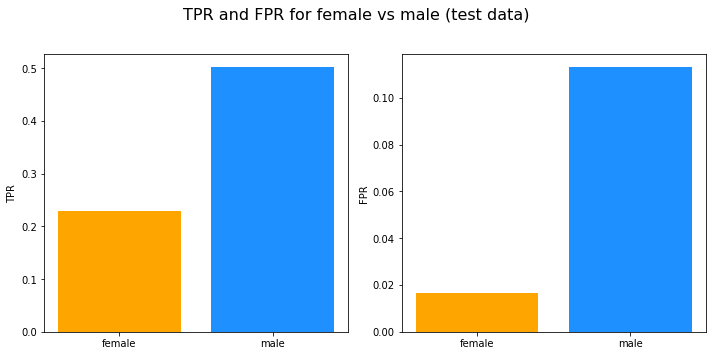

In [ ]:
# Run the binary classification pipeline on the original processed data and evaluation on training data
female_tup, male_tup = adult_binary_classification_pipeline(X_train, y_train, X_test, y_test, evaluate="test")

# Calculate and visualize TPR and FPR on the training data for female and male
TPR_f, TPR_m, FPR_f, FPR_m = adult_fairness_summary(female_tup, male_tup, show_plots=True, evaluate="test")

In [ ]:
# Calculate the difference in TPR (Equalized Opportunity distance)
TPR_diff_non_private = TPR_m-TPR_f

# Calculate the difference in FPR (second Equalized Odds distance)
FPR_diff_non_private = FPR_m-FPR_f

# Demographic parity (FP + TP rate difference)
dem_parity_non_private = (FPR_m+TPR_m)-(FPR_f+TPR_f)

# Calculate overall accuracy for female and male
ACC_f_non_private = (female_tup[0] + female_tup[2]) / sum(female_tup)
ACC_m_non_private = (male_tup[0] + male_tup[2]) / sum(male_tup)

print("TRAINING DATA METRICS:")
print(f"The difference in TPR (equalized opportunity) is: {TPR_diff_non_private:.4f}")
print(f"The difference in FPR (equalized odds) is: {FPR_diff_non_private:.4f}")
print(f"The difference in FP + TP rate (Demographic Parity) is: {dem_parity_non_private:.4f}")
print(f"The overall accuracy for female is: {ACC_f_non_private:.4f}")
print(f"The overall accuracy for male is: {ACC_m_non_private:.4f}")

TRAINING DATA METRICS:
The difference in TPR (equalized opportunity) is: 0.2725
The difference in FPR (equalized odds) is: 0.0963
The difference in FP + TP rate (Demographic Parity) is: 0.3688
The overall accuracy for female is: 0.8971
The overall accuracy for male is: 0.7638


## 4.1.2 MWEM

### 4.1.2.1 Testing

Based on multiplicative weight update mechanism; requires binning of continuous data.

In [ ]:
# Recombine X_train and y_train for synthesis
adult_train = pd.concat([X_train, y_train], axis=1)
adult_train

,age,workclass,education,education_num,occupation,relationship,race,sex,hours_week,label
15213,24,0,1,13,-2,2,0,0,50,0
5841,50,0,-2,14,0,-3,0,1,60,0
26610,41,1,-1,10,-2,2,-1,0,40,0
30332,39,0,0,9,3,-1,-1,1,40,0
26117,46,0,0,9,-3,0,0,1,50,0
...,...,...,...,...,...,...,...,...,...,...
13918,55,0,1,13,3,-2,0,0,40,0
20822,50,2,-1,10,1,-2,0,0,75,0
10456,27,0,2,11,3,-1,0,1,40,0
11475,28,1,-1,10,1,0,0,1,65,0


In [ ]:
# Recombine X_test and y_test for synthesis
adult_test = pd.concat([X_test, y_test], axis=1)

In [ ]:
# Create a MWEM synthesizer
mwem = MWEMSynthesizer(epsilon=1, q_count=500, iterations=30, mult_weights_iterations=15, 
                       splits=[], split_factor=2, max_bin_count=400)

# Fit synthesizer to the training data
mwem.fit(adult_train.to_numpy())

/work/smartnoise-sdk/synth/snsynth/mwem.py:229: Warning: Flattened dimensionality of synthetic histogram is less than the number of iterations. This is a privacy risk. Consider increasing your split_factor (especially if it is 1), or decreasing the number of iterations. Dim: 10 Split: [6 7]
  Warning,


In [ ]:
# Create private synthetic data using MWEM
adult_train_synth = pd.DataFrame(mwem.sample(int(adult_train.shape[0])), columns=adult_train.columns)
adult_train_synth

,age,workclass,education,education_num,occupation,relationship,race,sex,hours_week,label
0,62,-1,-1,10,-2,1,1,0,53,0
1,69,2,2,12,-3,-1,1,0,70,1
2,89,0,0,9,5,-3,0,0,30,0
3,90,-3,-1,10,2,-1,0,1,99,0
4,26,0,-4,14,-3,1,1,0,75,0
...,...,...,...,...,...,...,...,...,...,...
24569,25,-3,3,5,-4,0,0,1,59,1
24570,49,1,-1,10,-2,-2,1,0,80,1
24571,80,-2,1,13,-2,1,-1,0,46,1
24572,75,2,-1,10,-2,1,1,0,68,1


### 4.1.2.2 Varying $\varepsilon$

In [ ]:
def get_synthesizer(synthesizer, epsilon):

    # Instantiate an MWEM synthesizer
    if synthesizer == "MWEM":
        synth = MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15, 
        splits=[], split_factor=2, max_bin_count=400)

    return synth

In [ ]:
def get_quail_synthesizer(synthesizer, classifier, epsilon, eps_split, target):

    # Instantiate an MWEM synthesizer
    if synthesizer == "MWEM":
        def QuailSynth(epsilon):
            return MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15, 
                                    splits=[], split_factor=2, max_bin_count=400)
    
    # Instantiate a DPLR classifier
    if classifier == "DPLR":
        def QuailClassifier(epsilon):
            return DPLR(epsilon=epsilon)

    # Create a QUAIL synthesizer with base synthesizer and DP classifier
    quail = QUAILSynthesizer(epsilon, QuailSynth, QuailClassifier, target, eps_split)

    return quail

In [ ]:
def adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", 
                                    quail=False, classifier=None, eps_split=None, n_reps=1):
    '''
    Calculates fairness metrics for binary
    classification on Adult data obtained by
    training classifier on synthetic training
    data and testing on non-private test data.
    
    INPUTS
    ======
    epsilon_vals: list containing privacy loss
    parameter values to apply, array-like
    adult_train: non-private training data (X and 
    y) to train synthesizer, pandas DataFrame
    adult_test: non-private test data (X and y)
    synthesizer: the type of synthesizer to use, str
    n_reps: the number of synthetic data sets to
    generate for each epsilon, int
    
    RETURNS
    =======
    Dictionary where each key is an epsilon and 
    each value is a list of two tuples containing
    the average fairness metrics for female and male
    across the repetitions, i.e. the average values of
    (TP_f, FP_f, TN_f, FN_f), (TP_m, FP_m, TN_m, FN_m)
    '''
    
    # Initialize dictionary of fairness metrics
    fairness_dict = {}
    
    for epsilon in epsilon_vals:

        avg_female_tup, avg_male_tup = np.array([0,0,0,0]), np.array([0,0,0,0])

        for _ in range(n_reps):

            if quail:  
                # Create a QUAIL-wrapped synthesizer
                quail = get_quail_synthesizer(synthesizer, classifier, epsilon, eps_split, target="label")

                # Fit synthesizer to the training data
                quail.fit(adult_train)

                # Create private synthetic data
                adult_train_synth = quail.sample(int(adult_train.shape[0]))

            else:
                # Create a regular synthesizer
                synth = get_synthesizer(synthesizer, epsilon)
        
                # Fit synthesizer to the training data
                synth.fit(adult_train.to_numpy())
                
                # Create private synthetic data
                adult_train_synth = pd.DataFrame(synth.sample(int(adult_train.shape[0])), columns=adult_train.columns)
            
            # Split synthetic training data into X and y
            X_train, y_train = adult_train_synth.drop(["label"], axis=1), adult_train_synth["label"]
            
            # Split the non-private test data into X and y
            X_test, y_test = adult_test.drop(["label"], axis=1), adult_test["label"]
            
            # Run the binary classification pipeline
            female_tup, male_tup = adult_binary_classification_pipeline(X_train, y_train, X_test, y_test)
            female_tup = np.array(female_tup)
            male_tup = np.array(male_tup)

            # Add values to the average tuples
            avg_female_tup = np.sum([avg_female_tup, female_tup], axis=0)
            avg_male_tup = np.sum([avg_male_tup, male_tup], axis=0)
        
        # Calculate the averaged values
        avg_female_tup = np.divide(avg_female_tup, n_reps)
        avg_male_tup = np.divide(avg_male_tup, n_reps)

        # Add the tuples to dictionary
        fairness_dict[epsilon] = [avg_female_tup, avg_male_tup]
        
    return fairness_dict

In [ ]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

# Get dictionary of averaged fairness metrics across 5 repetitions for range of values
adult_fairness_dict = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", n_reps=5)

/work/smartnoise-sdk/synth/snsynth/mwem.py:229: Warning: Flattened dimensionality of synthetic histogram is less than the number of iterations. This is a privacy risk. Consider increasing your split_factor (especially if it is 1), or decreasing the number of iterations. Dim: 10 Split: [6 7]
  Warning,
/work/smartnoise-sdk/synth/snsynth/mwem.py:229: Warning: Flattened dimensionality of synthetic histogram is less than the number of iterations. This is a privacy risk. Consider increasing your split_factor (especially if it is 1), or decreasing the number of iterations. Dim: 10 Split: [6 7]
  Warning,
/work/smartnoise-sdk/synth/snsynth/mwem.py:229: Warning: Flattened dimensionality of synthetic histogram is less than the number of iterations. This is a privacy risk. Consider increasing your split_factor (especially if it is 1), or decreasing the number of iterations. Dim: 10 Split: [6 7]
  Warning,
/work/smartnoise-sdk/synth/snsynth/mwem.py:229: Warning: Flattened dimensionality of synthe

In [ ]:
def plot_fairness_dict(fairness_dict, plot_non_private=False):

    # Initialize a figure
    fig, axs = plt.subplots(2, 1, figsize=(12,16))
    axs = axs.ravel()

    # Initialize lists to hold epsilon and averaged metrics
    epsilon_list = []
    tpr_diff_list = []
    fpr_diff_list = []
    acc_f_list = []
    acc_m_list = []

    # Loop through the dictionary of results
    for epsilon, metric_list in fairness_dict.items():

        # Get the average true positive and false positive rates
        female_tup, male_tup = metric_list
        TPR_f, TPR_m, FPR_f, FPR_m = adult_fairness_summary(female_tup, male_tup)

        # Get the average equalized odds distances
        tpr_diff = TPR_m-TPR_f
        fpr_diff = FPR_m-FPR_f

        # Get the average accuracies
        ACC_f = (female_tup[0] + female_tup[2]) / sum(female_tup)
        ACC_m = (male_tup[0] + male_tup[2]) / sum(male_tup)

        # Add average metrics to lists
        epsilon_list.append(epsilon)
        tpr_diff_list.append(tpr_diff)
        fpr_diff_list.append(fpr_diff)
        acc_f_list.append(ACC_f)
        acc_m_list.append(ACC_m)

    # Plot the results
    min_eps = np.min(epsilon_list)
    max_eps = np.max(epsilon_list)
    if plot_non_private:
        axs[0].hlines(TPR_diff_non_private, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private TPR")
        axs[0].hlines(FPR_diff_non_private, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private FPR")
        axs[1].hlines(ACC_f_non_private, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private Female")
        axs[1].hlines(ACC_m_non_private, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private Male")
    axs[0].hlines(0, xmin=min_eps, xmax=max_eps, colors="grey", linestyles="--", label="Perfect fairness")
    axs[0].plot(epsilon_list, tpr_diff_list, label="TPR", c="darkorange", marker='o')
    axs[0].plot(epsilon_list, fpr_diff_list, label="FPR", c="royalblue", marker='o')
    axs[0].set_xlabel("Privacy loss (epsilon)")
    axs[0].set_ylabel("Equalized odds distance")
    axs[0].set_title("Equalized odds distances for female vs male")
    axs[0].legend()
    axs[1].plot(epsilon_list, acc_f_list, label="Female", c="darkorange", marker='o')
    axs[1].plot(epsilon_list, acc_m_list, label="Male", c="royalblue", marker='o')
    axs[1].set_xlabel("Privacy loss (epsilon)")
    axs[1].set_ylabel("Overall accuracy")
    axs[1].set_title("Classification accuracies for female vs male")
    axs[1].legend()

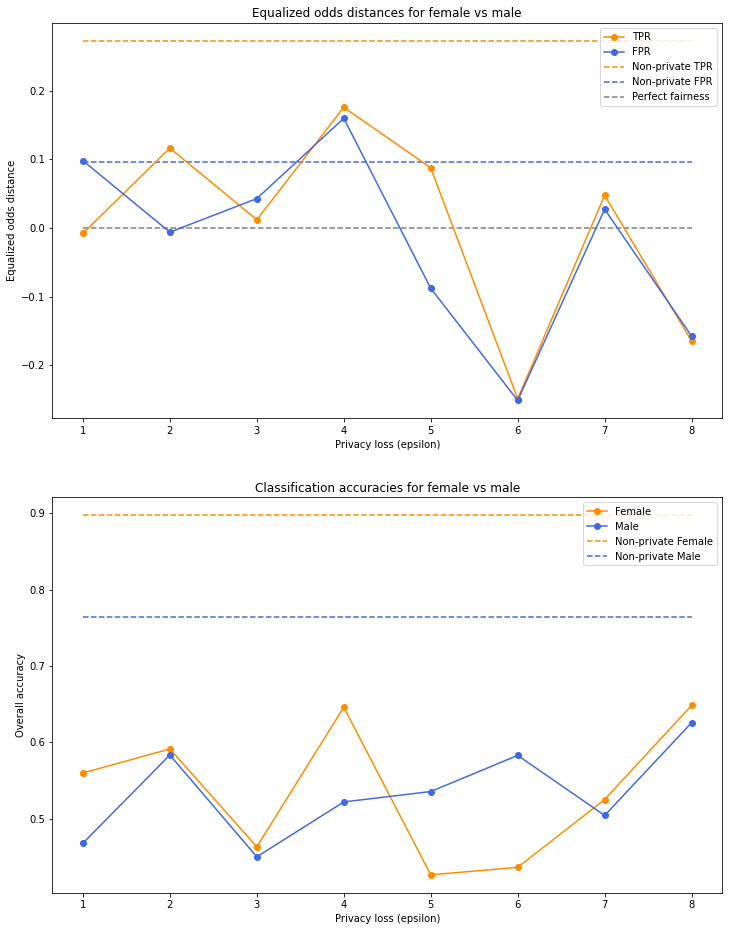

In [ ]:
# Plot the fairness and accuracy metrics for female vs male
plot_fairness_dict(adult_fairness_dict, plot_non_private=True)

In [ ]:
# Set range of epsilon values
epsilon_vals = [0.01, 0.1, 0.5, 1.0, 3.0, 6.0, 9.0]

# Get dictionary of averaged fairness metrics across 10 repetitions for range of values
adult_fairness_dict_2 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", n_reps=10)

/work/smartnoise-sdk/synth/snsynth/mwem.py:229: Warning: Flattened dimensionality of synthetic histogram is less than the number of iterations. This is a privacy risk. Consider increasing your split_factor (especially if it is 1), or decreasing the number of iterations. Dim: 10 Split: [6 7]
  Warning,
/work/smartnoise-sdk/synth/snsynth/mwem.py:229: Warning: Flattened dimensionality of synthetic histogram is less than the number of iterations. This is a privacy risk. Consider increasing your split_factor (especially if it is 1), or decreasing the number of iterations. Dim: 10 Split: [6 7]
  Warning,
/work/smartnoise-sdk/synth/snsynth/mwem.py:229: Warning: Flattened dimensionality of synthetic histogram is less than the number of iterations. This is a privacy risk. Consider increasing your split_factor (especially if it is 1), or decreasing the number of iterations. Dim: 10 Split: [6 7]
  Warning,
/work/smartnoise-sdk/synth/snsynth/mwem.py:229: Warning: Flattened dimensionality of synthe

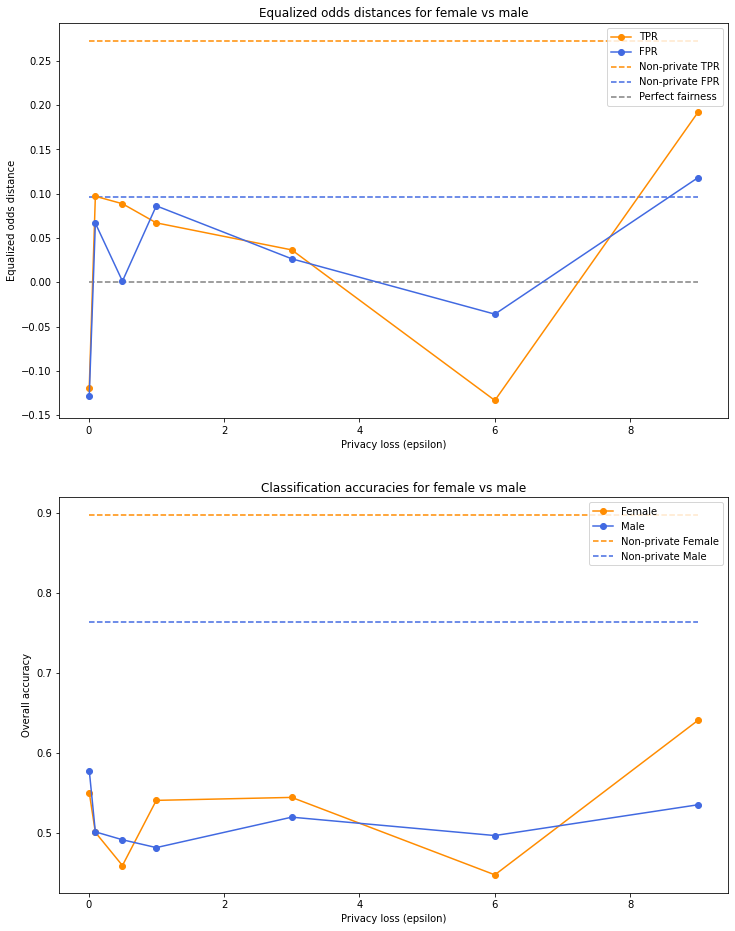

In [ ]:
# Plot the fairness and accuracy metrics for female vs male
plot_fairness_dict(adult_fairness_dict_2, plot_non_private=True)

- visualize the distribution at each epsilon (boxplots / error bars)

## 4.3 QUAIL

In [ ]:
adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", 
                                    quail=False, classifier=None, eps_split=None, n_reps=1)

In [ ]:
# Set range of epsilon values
epsilon_vals = [0.01]#, 0.1, 0.5, 1.0, 3.0, 6.0, 9.0]

# Get dictionary of averaged fairness metrics across 10 repetitions for range of values using QUAIL+MWEM
adult_fairness_dict_quail = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", 
                                                        quail=True, classifier="DPLR", eps_split=0.8, n_reps=1)

/root/venv/lib/python3.7/site-packages/diffprivlib/models/logistic_regression.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/work/smartnoise-sdk/synth/snsynth/mwem.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors="ignore")
/work/smartnoise-sdk/synth/snsynth/mwem.py:229: Warning: Flattened dimensionality of synthetic histogram is less than the number of iterations. This is a privacy risk. Consider increasing y

ValueError: Shape of passed values is (24574, 8), indices imply (24574, 9)

## 4.4 DPCTGAN

In [ ]:
dpctgan = PytorchDPSynthesizer(3.0, DPCTGAN(), None)
dpctgan.fit(adult_train, categorical_columns=["workclass", "education", "occupation", "relationship", "race", "sex", "label"])

TypeError: __init__() takes 1 positional argument but 2 positional arguments (and 3 keyword-only arguments) were given

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aa928c63-0856-4021-a156-02d09e35182a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>